In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'notebooks'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/notebooks


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13334677844287411050
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3332507461602324044
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [54]:
import numpy as np
import tensorflow as tf
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, concatenate, PReLU, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model

dataset = np.load("./dataset.npy", allow_pickle=True)
sar = [ entry["sarImage"] for entry in dataset]

height = [ s.shape[0] for s in sar ]
width = [ s.shape[1] for s in sar ]

maxWidth = max(width)
maxHeight = max(height)

sar = np.array([np.pad(s, [(0, maxHeight - s.shape[0]),(0, maxWidth - s.shape[1]),(0,0)]) for s in sar])
ndvi = np.array([ entry["y"] for entry in dataset])
lastNDVI = np.array([ entry["lastNDVI"] for entry in dataset])
ids = np.array([ entry["id"] for entry in dataset])
lastNDVIDays = np.array([ entry["lastNDVITakenBefore"] for entry in dataset])


sarShape = sar[0].shape
lastNDVIShape = lastNDVI[0].shape
ndviShape = ndvi[0].shape
ndviReshaped = ndvi.reshape([ndvi.shape[0], ndvi.shape[1] * ndvi.shape[2]])

flatLastNDVI = np.reshape(lastNDVI, [lastNDVI.shape[0], lastNDVIShape[0] * lastNDVIShape[1]])
lastNDVIDays = np.reshape(lastNDVIDays, [lastNDVIDays.shape[0], 1])
flatLastNDVI = np.hstack((flatLastNDVI, lastNDVIDays))

trainID, testID, trainX, testX, trainLastNDVI, testLastNDVI, trainY, testY = train_test_split(ids, sar, flatLastNDVI, ndviReshaped, test_size=0.20, random_state=48)
print("Sar train: ", trainX.shape)
print("lastNDVI train: ", trainLastNDVI.shape)
print("NDVI train: ", trainY.shape)

print("Sar test: ", testX.shape)
print("lastNDVI test: ", testLastNDVI.shape)
print("NDVI train: ", testY.shape)

Sar train:  (134, 114, 81, 2)
lastNDVI train:  (134, 8095)
NDVI train:  (134, 8094)
Sar test:  (34, 114, 81, 2)
lastNDVI test:  (34, 8095)
NDVI train:  (34, 8094)


In [68]:
inputSar = Input(shape=(None, None, 2))
img = BatchNormalization()(inputSar)
img = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(2, 2))(img)
img = Dropout(0.2)(img)
img = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(2, 2))(img)
img = Dropout(0.2)(img)
img = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same')(img)
img = MaxPool2D(pool_size=(4, 4))(img)
img = GlobalAveragePooling2D()(img)
img = Model(inputs=inputSar, outputs=img)

print(img.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 2)]   0         
                                                                 
 batch_normalization_3 (Batc  (None, None, None, 2)    8         
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, None, None, 64)    0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 128)   738

In [43]:
inputLastNDVI = Input(shape=lastNDVIShape[0] * lastNDVIShape[1] + 1)
lndvi = Dense(8095, activation='relu')(inputLastNDVI)
lndvi = Model(inputs=inputLastNDVI, outputs=lndvi)
print(lndvi.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8095)]            0         
                                                                 
 dense_3 (Dense)             (None, 8095)              65537120  
                                                                 
Total params: 65,537,120
Trainable params: 65,537,120
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
inputLastNDVI = Input(shape=lastNDVIShape[0] * lastNDVIShape[1] + 1)
lndvi = Dense(8095, activation='relu')(inputLastNDVI)
lndvi = Model(inputs=inputLastNDVI, outputs=lndvi)
print(lndvi.summary()

In [69]:
combined = concatenate([img.output, lndvi.output])
model = Dense(1000, activation="relu")(combined)
model = Dense(ndviReshaped.shape[1])(model)
model = PReLU()(model)
model = Model(inputs=[img.input, lndvi.input], outputs=model)

print(model.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 2)]                                                              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, None, None,   8          ['input_6[0][0]']                
 rmalization)                   2)                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, None, None,   1216        ['batch_normalization_3[0][0]']  
                                64)                                                        

In [70]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, weight_decay=0.01), loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [74]:
print(testID)

['s1a-20220723-20220724' 's1b-20210510-20210510' 's1b-20210304-20210303'
 's1a-20220228-20220226' 's1a-20220116-20220115' 's1a-20221101-20221103'
 's1a-20211118-20211118' 's1b-20210827-20210828' 's1a-20210505-20210507'
 's1a-20220524-20220525' 's1a-20220616-20220614' 's1a-20230424-20230422'
 's1b-20210721-20210721' 's1a-20210716-20210716' 's1a-20210704-20210704'
 's1b-20211118-20211118' 's1a-20220621-20220621' 's1a-20230605-20230606'
 's1a-20220722-20220721' 's1b-20210710-20210711' 's1b-20210604-20210606'
 's1a-20220517-20220517' 's1a-20220528-20220527' 's1a-20210209-20210209'
 's1a-20220417-20220415' 's1a-20220325-20220326' 's1b-20210908-20210909'
 's1a-20220803-20220803' 's1a-20220609-20220609' 's1a-20221027-20221027'
 's1b-20210815-20210815' 's1b-20211030-20211029' 's1a-20220704-20220704'
 's1b-20211019-20211019']


In [71]:
history = model.fit(
    x=[trainX, trainLastNDVI],
    y=trainY,
    epochs=30,
    verbose='auto',
    validation_split=0.2)

Epoch 1/30
4/4 [==============================] - 4s 164ms/step - loss: 0.0679 - root_mean_squared_error: 0.2606 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 2/30
4/4 [==============================] - 0s 71ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 3/30
4/4 [==============================] - 0s 66ms/step - loss: 0.0373 - root_mean_squared_error: 0.1931 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1745
Epoch 4/30
4/4 [==============================] - 0s 70ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1718
Epoch 5/30
4/4 [==============================] - 0s 71ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 6/30
4/4 [==============================] - 0s 69ms/step - loss: 0.0328 - root_mean_squared_error: 0.1812 - val_loss: 0.0281 - val_root_mean_squared

In [ ]:
from keras import backend as k

input_images_tensor = tf.cast(tf.constant(trainX), tf.float32)
last_ndvi_tensor = tf.constant(trainLastNDVI)
with tf.GradientTape() as g:
    g.watch(input_images_tensor)
    g.watch(last_ndvi_tensor)
    output_tensor = model([input_images_tensor, last_ndvi_tensor])

gradients = g.gradient(output_tensor, input_images_tensor)
gradients < 0.0001


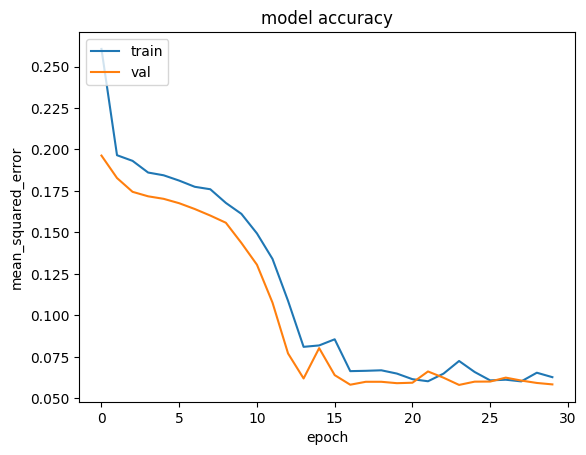

In [72]:
from matplotlib import pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [73]:
model.evaluate([testX, testLastNDVI], testY)

2/2 [==============================] - 0s 10ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668


[0.004457482602447271, 0.06676437705755234]

In [96]:
model.save("top_model.keras")

In [84]:
dataset_plus = np.load("./dataset-plus.npy", allow_pickle=True)

entry = dataset_plus[2]


sar = np.reshape(entry['sarImage'], (1, entry['sarImage'].shape[0], entry['sarImage'].shape[1], entry['sarImage'].shape[2]))
lastNDVI = np.reshape(entry['lastNDVI'], (1, entry['lastNDVI'].shape[0], entry['lastNDVI'].shape[1]))

model.predict([[sar], [lastNDVI]])




ValueError: ignored

In [32]:
from keras import backend as K
import psutil


# Check the GPU memory usage
gpu_memory_used = psutil.virtual_memory().used
gpu_memory_total = psutil.virtual_memory().total
gpu_memory_percent = (gpu_memory_used / gpu_memory_total) * 100

print(gpu_memory_percent)

K.clear_session()

32.85708740890424
